<a href="https://colab.research.google.com/github/Birkbeck/msc-projects-2023-4-chorltonm/blob/main/notebooks/models/rating_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Import Libaries
import os
import sys
import json
import pandas as pd
import numpy as np
import importlib
import pandas_gbq

from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Install scikit learn
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report


In [31]:
# Install Trueskill library
!pip install trueskill
from trueskill import Rating, rate_1vs1

In [32]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

# List the contents of the directory
contents = os.listdir(current_directory)

# Print the contents
print("Contents of the directory:", contents)

# Import user defined python functions. Used importlib as having stability issues with simple import and not picking up the files
spec = importlib.util.spec_from_file_location("create_model_results", "/content/drive/MyDrive/birkbeck_msc-project/python_files/create_model_results.py")
create_model_results = importlib.util.module_from_spec(spec)
spec.loader.exec_module(create_model_results)

spec = importlib.util.spec_from_file_location("ratings_functions", "/content/drive/MyDrive/birkbeck_msc-project/python_files/ratings_functions.py")
ratings_functions = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ratings_functions)

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/birkbeck_msc-project/python_files
Contents of the directory: ['__pycache__', 'ratings_functions.py', 'model_evaluation_functions.py', 'create_model_results.py']


In [33]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [34]:
def load_predictions_and_ratings_to_bigquery(client, predictions_df, fold_ratings_df, ratings_model):

  # Load predictions to Big Query
  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings_predictions'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete predicitons method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  predictions_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target predictions table {load_dataset_name}.{load_table_name} rows deleted: {predictions_total_rows_deleted}")

  # Insert predictions for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          predictions_df, load_table_ref, job_config=job_config)
  # Wait for the job to complete
  load_job.result()
  predictions_num_rows_inserted = load_job.output_rows
  print(f"{predictions_num_rows_inserted} rows appended to predictions table {load_table_ref} successfully.")

  # Load fold ratings to Big Query

  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete ratings method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  ratings_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target ratings table {load_dataset_name}.{load_table_name} rows deleted: {ratings_total_rows_deleted}")


  # Insert ratings for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          ratings_df, load_table_ref, job_config=job_config)

  load_job.result()  # Wait for the job to complete

  ratings_num_rows_inserted = load_job.output_rows
  print(f"{ratings_num_rows_inserted} rows appended to ratings table {load_table_ref} successfully.")

  return


In [35]:
# FA Cup Data 13 season from 08/09 to 21/20

fa_cup_scores = """
    SELECT * FROM preparation_layer.view_fa_cup_scores WHERE season_year NOT IN ('21/22', '22/23') ORDER BY sort_order ASC
"""

fa_cup_scores_df = client.query(fa_cup_scores).to_dataframe()
display(fa_cup_scores_df)




,season_year,match_id,match_date,home_team_no,home_team_name,home_team_league_level,home_team_score,away_team_no,away_team_name,away_team_league_level,away_team_score,actual_winning_team_no,actual_losing_team_no,home_win,away_win,actual_upset,sort_order,match_count
0,08/09,1428623,2009-01-03,27,Preston North End,2,0,1,Liverpool,1,2,1,27,0,1,0,1,1
1,09/10,505337,2010-01-03,1,Chelsea,1,5,34,Watford,2,0,1,34,1,0,0,1,1
2,14/15,1138603,2015-01-04,1,Chelsea,1,3,25,Watford,2,0,1,25,1,0,0,1,1
3,16/17,1345813,2017-01-08,1,Chelsea,1,4,48,Peterborough United,3,1,1,48,1,0,0,1,1
4,20/21,201912,2021-01-09,1,Manchester United,1,1,25,Watford,2,0,1,25,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,09/10,475990,2010-01-19,58,Accrington Stanley,4,1,54,Gillingham,3,0,58,54,1,0,1,54,1
301,09/10,507052,2010-01-02,60,Torquay United,4,0,55,Brighton & Hove Albion,3,1,55,60,0,1,0,55,1
302,16/17,1349585,2017-01-07,55,Wycombe Wanderers,4,2,64,Stourbridge,6,1,55,64,1,0,0,55,1
303,09/10,476038,2010-01-19,57,Notts County,4,2,64,Forest Green Rovers,5,1,57,64,1,0,0,57,1


In [36]:
def predict_winner_upset (home_team_no, away_team_no, home_team_league_level, away_team_league_level, ranked_ratings):
    home_team_info = next((info for info in ranked_ratings if info[0] == home_team_no), None)
    away_team_info = next((info for info in ranked_ratings if info[0] == away_team_no), None)

    if home_team_info is None or away_team_info is None:
        raise ValueError("Team number not found in ratings list.")

    home_team_rating, home_team_rank = home_team_info[1], home_team_info[2]
    away_team_rating, away_team_rank = away_team_info[1], away_team_info[2]

    # Calculate the basic probability of the higer ranked team winning based proportionally as part of the total rank. Calculation reflects the fact lowest number is higher rank

    home_team_upset_probability = 1 - (home_team_rank / (home_team_rank + away_team_rank))
    away_team_upset_probability = 1 - (away_team_rank / (home_team_rank + away_team_rank))


    # Determine the predicted winner and if it's an upset
    if home_team_rating > away_team_rating:
        predicted_winner = home_team_no
        predicted_upset = 1 if home_team_league_level > away_team_league_level else 0
    else:
        predicted_winner = away_team_no
        predicted_upset = 1 if away_team_league_level > home_team_league_level else 0

    # Probaility of upset based on league level and rank differnce
    if home_team_league_level > away_team_league_level:
       upset_probability = home_team_upset_probability
    else:
       upset_probability = away_team_upset_probability

    return predicted_winner, predicted_upset, home_team_rating, away_team_rating, home_team_rank, away_team_rank, upset_probability

In [37]:
def run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds, random_state=47):
    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    # Initialize lists to store results
    train_accuracies = []
    train_recalls = []
    test_accuracies = []
    test_recalls = []
    all_y_train_true = []
    all_y_train_pred = []
    all_y_train_pred_proba = []
    all_y_test_true = []
    all_y_test_pred = []
    all_y_test_pred_proba = []
    fold_ratings = []
    test_predictions = []

    # Iterate over the folds
    for fold, (train_idx, test_idx) in enumerate(skf.split(fa_cup_scores_df, fa_cup_scores_df['actual_upset']), start=1):
        print(f"Fold {fold}/{num_folds}")

        # Split the data into training and test sets
        train_data = fa_cup_scores_df.iloc[train_idx]
        test_data = fa_cup_scores_df.iloc[test_idx]

        # Call rating function
        if ratings_model in ['borda_count', 'average_rank', 'local_kemeny_optimisation']:
            ratings = ratings_function(fold)
        else:
            ratings = ratings_function(train_data)

        # Add ranks based on the sorted order
        sorted_ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        ranked_ratings = [(team_no, rating, index + 1) for index, (team_no, rating) in enumerate(sorted_ratings)]

        # Append the ratings to the list
        ratings_list = [(ratings_model, fold, team_no, rating) for team_no, rating in ratings]
        fold_ratings.extend(ratings_list)

        # Predict upsets for train data
        train_actual_upsets = []
        train_predicted_upsets = []
        train_upset_probabilities = []

        for _, row in train_data.iterrows():
            predicted_winner, predicted_upset, home_team_rating, away_team_rating,  home_team_rank, away_team_rank, upset_probability = predict_winner_upset(
                row['home_team_no'], row['away_team_no'],
                row['home_team_league_level'], row['away_team_league_level'],
                ranked_ratings
            )
            actual_upset = row['actual_upset']
            train_actual_upsets.append(actual_upset)
            train_predicted_upsets.append(predicted_upset)
            train_upset_probabilities.append(upset_probability)

        # Calculate train metrics
        train_accuracy = accuracy_score(train_actual_upsets, train_predicted_upsets)
        train_recall = recall_score(train_actual_upsets, train_predicted_upsets)
        train_accuracies.append(train_accuracy)
        train_recalls.append(train_recall)
        all_y_train_true.extend(train_actual_upsets)
        all_y_train_pred.extend(train_predicted_upsets)
        all_y_train_pred_proba.extend(train_upset_probabilities)

        # Predict upsets for test data
        test_actual_upsets = []
        test_predicted_upsets = []
        test_upset_probabilities = []

        for _, row in test_data.iterrows():
            predicted_winner, predicted_upset, home_team_rating, away_team_rating, home_team_rank, away_team_rank, upset_probability = predict_winner_upset(
                row['home_team_no'], row['away_team_no'],
                row['home_team_league_level'], row['away_team_league_level'],
                ranked_ratings
            )
            actual_upset = row['actual_upset']
            rating_diff = home_team_rating - away_team_rating
            test_actual_upsets.append(actual_upset)
            test_predicted_upsets.append(predicted_upset)
            test_upset_probabilities.append(upset_probability)

            test_predictions.append({
              'ratings_model': ratings_model,
              'fold_number': fold,
              'match_id': row['match_id'],
              'home_team_no': row['home_team_no'],
              'home_team_league_level': row['home_team_league_level'],
              'away_team_no': row['away_team_no'],
              'away_team_league_level': row['away_team_league_level'],
              'home_team_rating': home_team_rating,
              'away_team_rating': away_team_rating,
              'home_team_rank': home_team_rank,
              'away_team_rank': away_team_rank,
              'predicted_winner': predicted_winner,
              'actual_winner': row['actual_winning_team_no'],
              'actual_upset': actual_upset,
              'predicted_upset': predicted_upset,
              'upset_probability': upset_probability,
            })

        # Calculate test metrics
        test_accuracy = accuracy_score(test_actual_upsets, test_predicted_upsets)
        test_recall = recall_score(test_actual_upsets, test_predicted_upsets)
        test_accuracies.append(test_accuracy)
        test_recalls.append(test_recall)
        all_y_test_true.extend(test_actual_upsets)
        all_y_test_pred.extend(test_predicted_upsets)
        all_y_test_pred_proba.extend(test_upset_probabilities)

        print(f"Fold {fold} Train Accuracy: {train_accuracy:.3f}, Train Recall: {train_recall:.3f}")
        print(f"Fold {fold} Test Accuracy: {test_accuracy:.3f}, Test Recall: {test_recall:.3f}")

        test_predictions_df = pd.DataFrame(test_predictions)


        # Fold ratings dataframe
        fold_ratings_df = pd.DataFrame(fold_ratings, columns=['ratings_model','fold_number','team_no', 'rating'])
        fold_ratings_df = fold_ratings_df.sort_values('team_no', ascending=True)
        #fold_ratings_df.index = range(1, len(fold_ratings) + 1)
        fold_ratings_df['rank'] = fold_ratings_df.groupby('fold_number')['rating'].rank(ascending=False, method='dense').astype(int)

        # Mean ratings from 5 folds. Assign 0 fold as mean
        mean_ratings_df = fold_ratings_df.groupby('team_no')['rating'].mean().reset_index()
        mean_ratings_by_team_df = pd.DataFrame({'ratings_model': ratings_model, 'fold_number': 0,'team_no': mean_ratings_df['team_no'],'rating': mean_ratings_df['rating']})
        mean_ratings_by_team_df = mean_ratings_by_team_df.sort_values('rating', ascending=False)
        mean_ratings_by_team_df['rank'] = mean_ratings_by_team_df.groupby('fold_number')['rating'].rank(ascending=False, method='dense').astype(int)

        # Combine and sort DataFrame
        ratings_df = pd.concat([fold_ratings_df, mean_ratings_by_team_df], ignore_index=True)
        ratings_df = ratings_df.sort_values(['team_no', 'fold_number'], ascending=[True, True])

    return ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, ratings_model

In [38]:
# Results & Rank Dataframes
all_ranks_df = pd.DataFrame(columns=['team_no','fold_number'])
display(all_ranks_df)

all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)

test_flag = 'Cross-Validation'

,team_no,fold_number


,metric_id,metric


Fold 1/5
Fold 1 Train Accuracy: 0.730, Train Recall: 0.000
Fold 1 Test Accuracy: 0.738, Test Recall: 0.000
Fold 2/5
Fold 2 Train Accuracy: 0.730, Train Recall: 0.000
Fold 2 Test Accuracy: 0.738, Test Recall: 0.000
Fold 3/5
Fold 3 Train Accuracy: 0.730, Train Recall: 0.000
Fold 3 Test Accuracy: 0.738, Test Recall: 0.000
Fold 4/5
Fold 4 Train Accuracy: 0.734, Train Recall: 0.000
Fold 4 Test Accuracy: 0.721, Test Recall: 0.000
Fold 5/5
Fold 5 Train Accuracy: 0.734, Train Recall: 0.000
Fold 5 Test Accuracy: 0.721, Test Recall: 0.000


,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,basic_position,1,1428623,27,2,1,1,0.037037,1.000000,27,1,1,1,0,0,0.035714
2,basic_position,1,201912,1,1,25,2,1.000000,0.040000,1,25,1,1,0,0,0.038462
3,basic_position,1,1324961,54,4,2,1,0.018519,0.500000,54,2,2,2,0,0,0.035714
4,basic_position,1,50127,2,1,41,2,0.500000,0.024390,2,41,2,2,0,0,0.046512
5,basic_position,1,846113,2,1,42,2,0.500000,0.023810,2,42,2,2,0,0,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,basic_position,5,274803,58,4,40,2,0.017241,0.025000,58,40,40,40,0,0,0.408163
302,basic_position,5,304202,42,2,55,3,0.023810,0.018182,42,55,42,55,1,0,0.432990
303,basic_position,5,1041547,46,3,57,4,0.021739,0.017544,46,57,46,46,0,0,0.446602
304,basic_position,5,836539,47,3,64,6,0.021277,0.015625,47,64,47,47,0,0,0.423423


,ratings_model,fold_number,team_no,rating,rank
1,basic_position,0,1,1.000000,1
2,basic_position,1,1,1.000000,1
3,basic_position,2,1,1.000000,1
4,basic_position,3,1,1.000000,1
5,basic_position,4,1,1.000000,1
...,...,...,...,...,...
380,basic_position,1,64,0.015625,64
381,basic_position,2,64,0.015625,64
382,basic_position,3,64,0.015625,64
383,basic_position,4,64,0.015625,64


Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position
0,1,0,1
1,1,1,1
2,1,2,1
3,1,3,1
4,1,4,1
...,...,...,...
379,64,1,64
380,64,2,64
381,64,3,64
382,64,4,64


0.7311475409836067
Model name received: 'basic_position'
0.5373193183111064
0.5373193183111064


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric_id,metric,basic_position
0,1,Cross-Validation Train Accuracy Mean,0.731
1,2,Cross-Validation Train Standard Deviation,0.002
2,3,Cross-Validation Test Accuracy Mean,0.731
3,4,Cross-Validation Test Accuracy Standard Deviation,0.008
4,5,Cross-Validation Train Recall Mean,0.000
5,6,Cross-Validation Train Recall Standard Deviation,0.000
6,7,Cross-Validation Test Recall Mean,0.000
7,8,Cross-Validation Test Recall Standard Deviation,0.000
8,9,Cross-Validation Train Log Loss,0.537
9,10,Cross-Validation Test Log Loss,0.537


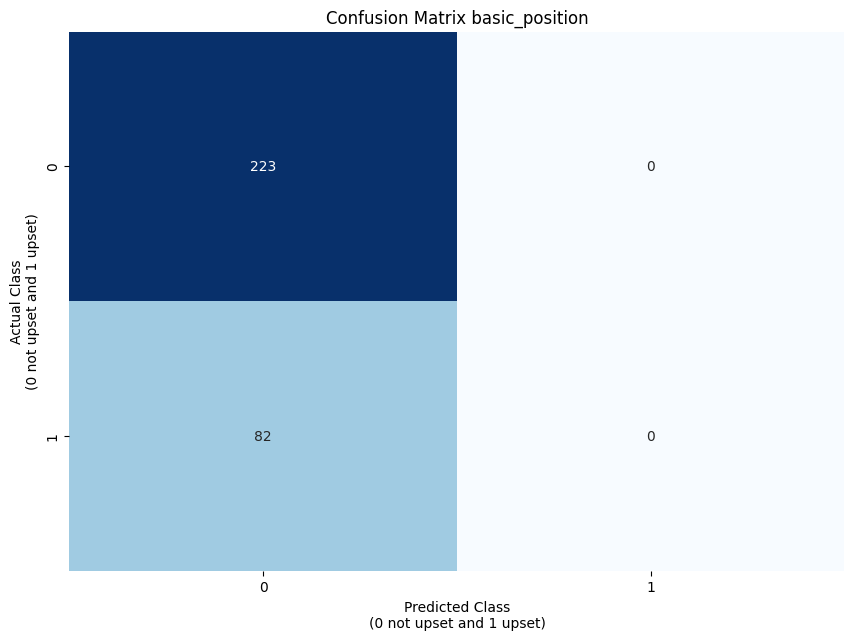

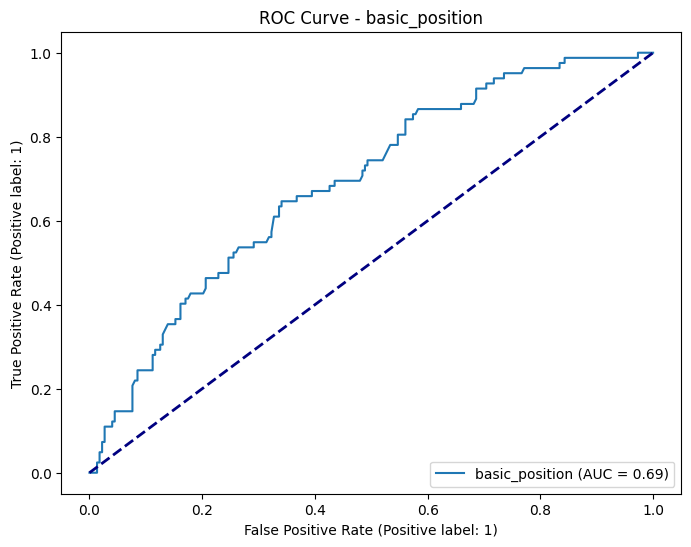

In [39]:
# Basic Position Ratings
ratings_model = 'basic_position'
ratings_function = ratings_functions.basic_position_ratings
num_folds = 5

# Call ratings function and run cross validation
(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
avg_train_accuracy = np.mean(train_accuracies)
print(avg_train_accuracy)
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



Fold 1/5
244
Fold 1 Train Accuracy: 0.787, Train Recall: 0.439
Fold 1 Test Accuracy: 0.738, Test Recall: 0.250
Fold 2/5
244
Fold 2 Train Accuracy: 0.820, Train Recall: 0.485
Fold 2 Test Accuracy: 0.590, Test Recall: 0.188
Fold 3/5
244
Fold 3 Train Accuracy: 0.787, Train Recall: 0.364
Fold 3 Test Accuracy: 0.754, Test Recall: 0.375
Fold 4/5
244
Fold 4 Train Accuracy: 0.799, Train Recall: 0.446
Fold 4 Test Accuracy: 0.705, Test Recall: 0.353
Fold 5/5
244
Fold 5 Train Accuracy: 0.775, Train Recall: 0.354
Fold 5 Test Accuracy: 0.689, Test Recall: 0.176


,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,massey,1,1428623,27,2,1,1,0.818891,3.684980,18,1,1,1,0,0,0.052632
2,massey,1,201912,1,1,25,2,3.684980,1.367271,1,10,1,1,0,0,0.090909
3,massey,1,1324961,54,4,2,1,-1.752165,2.140011,61,4,2,2,0,0,0.061538
4,massey,1,50127,2,1,41,2,2.140011,-0.505573,4,41,2,2,0,0,0.088889
5,massey,1,846113,2,1,42,2,2.140011,0.014988,4,27,2,2,0,0,0.129032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,massey,5,274803,58,4,40,2,-0.732169,-0.591081,46,42,40,40,0,0,0.477273
302,massey,5,304202,42,2,55,3,-0.168910,-0.760065,31,48,42,55,1,0,0.392405
303,massey,5,1041547,46,3,57,4,-0.005877,-0.615840,29,44,46,46,0,0,0.397260
304,massey,5,836539,47,3,64,6,0.695473,-1.298919,19,59,47,47,0,0,0.243590


,ratings_model,fold_number,team_no,rating,rank
1,massey,0,1,3.504874,1
2,massey,1,1,3.684980,1
3,massey,2,1,3.357780,1
4,massey,3,1,3.518797,1
5,massey,4,1,4.057460,1
...,...,...,...,...,...
380,massey,1,64,-1.412519,56
381,massey,2,64,-1.780993,62
382,massey,3,64,-1.553854,60
383,massey,4,64,-1.161723,57


Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey
0,1,0,1,1
1,1,1,1,1
2,1,2,1,1
3,1,3,1,1
4,1,4,1,1
...,...,...,...,...
379,64,1,64,56
380,64,2,64,62
381,64,3,64,60
382,64,4,64,57


Model name received: 'massey'
0.4717635899492885
0.5759065826136204


,metric_id,metric,basic_position,massey
0,1,Cross-Validation Train Accuracy Mean,0.731,0.793
1,2,Cross-Validation Train Standard Deviation,0.002,0.015
2,3,Cross-Validation Test Accuracy Mean,0.731,0.695
3,4,Cross-Validation Test Accuracy Standard Deviation,0.008,0.057
4,5,Cross-Validation Train Recall Mean,0.000,0.418
5,6,Cross-Validation Train Recall Standard Deviation,0.000,0.051
6,7,Cross-Validation Test Recall Mean,0.000,0.268
7,8,Cross-Validation Test Recall Standard Deviation,0.000,0.082
8,9,Cross-Validation Train Log Loss,0.537,0.472
9,10,Cross-Validation Test Log Loss,0.537,0.576


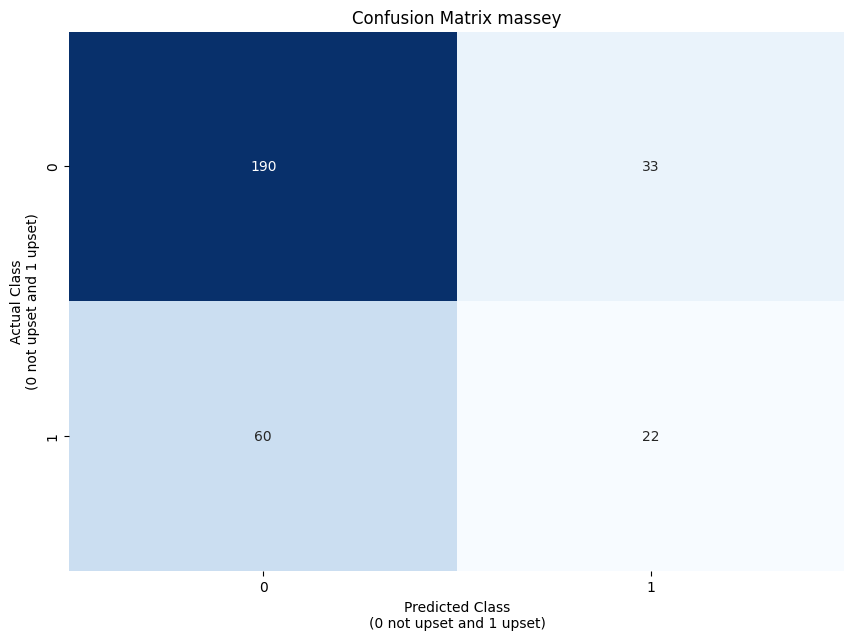

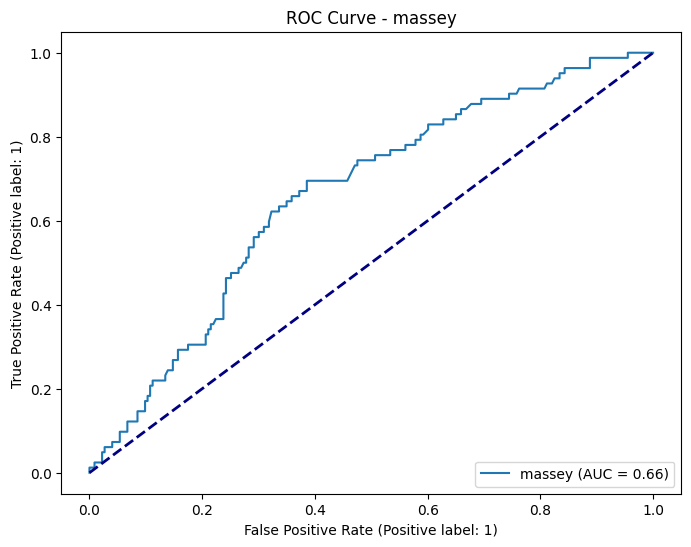

In [40]:
# Massey Ratings
ratings_model = 'massey'
ratings_function = ratings_functions.massey_ratings
num_folds = 5

# Call ratings function and run cross validation
(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)


Fold 1/5
244
Fold 1 Train Accuracy: 0.836, Train Recall: 0.485
Fold 1 Test Accuracy: 0.770, Test Recall: 0.312
Fold 2/5
244
Fold 2 Train Accuracy: 0.832, Train Recall: 0.591
Fold 2 Test Accuracy: 0.639, Test Recall: 0.250
Fold 3/5
244
Fold 3 Train Accuracy: 0.807, Train Recall: 0.455
Fold 3 Test Accuracy: 0.770, Test Recall: 0.500
Fold 4/5
244
Fold 4 Train Accuracy: 0.832, Train Recall: 0.554
Fold 4 Test Accuracy: 0.639, Test Recall: 0.235
Fold 5/5
244
Fold 5 Train Accuracy: 0.820, Train Recall: 0.492
Fold 5 Test Accuracy: 0.656, Test Recall: 0.294


,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,colley,1,1428623,27,2,1,1,0.608991,0.788631,21,5,1,1,0,0,0.192308
2,colley,1,201912,1,1,25,2,0.788631,0.735270,5,11,1,1,0,0,0.312500
3,colley,1,1324961,54,4,2,1,0.262963,0.741901,59,9,2,2,0,0,0.132353
4,colley,1,50127,2,1,41,2,0.741901,0.476014,9,32,2,2,0,0,0.219512
5,colley,1,846113,2,1,42,2,0.741901,0.389506,9,42,2,2,0,0,0.176471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,colley,5,274803,58,4,40,2,0.438291,0.299029,37,54,58,40,0,1,0.593407
302,colley,5,304202,42,2,55,3,0.400770,0.566775,42,24,55,55,1,1,0.636364
303,colley,5,1041547,46,3,57,4,0.579372,0.293190,21,55,46,46,0,0,0.276316
304,colley,5,836539,47,3,64,6,0.571726,0.160732,22,64,47,47,0,0,0.255814


,ratings_model,fold_number,team_no,rating,rank
1,colley,0,1,0.860781,1
2,colley,1,1,0.788631,5
3,colley,2,1,0.884865,1
4,colley,3,1,0.888967,1
5,colley,4,1,0.896172,1
...,...,...,...,...,...
380,colley,1,64,0.147159,64
381,colley,2,64,0.084938,64
382,colley,3,64,0.165452,64
383,colley,4,64,0.166364,64


Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley
0,1,0,1,1,1
1,1,1,1,1,5
2,1,2,1,1,1
3,1,3,1,1,1
4,1,4,1,1,1
...,...,...,...,...,...
379,64,1,64,56,64
380,64,2,64,62,64
381,64,3,64,60,64
382,64,4,64,57,64


Model name received: 'colley'
0.4422454239388764
0.5627410168090942


,metric_id,metric,basic_position,massey,colley
0,1,Cross-Validation Train Accuracy Mean,0.731,0.793,0.825
1,2,Cross-Validation Train Standard Deviation,0.002,0.015,0.011
2,3,Cross-Validation Test Accuracy Mean,0.731,0.695,0.695
3,4,Cross-Validation Test Accuracy Standard Deviation,0.008,0.057,0.062
4,5,Cross-Validation Train Recall Mean,0.000,0.418,0.515
5,6,Cross-Validation Train Recall Standard Deviation,0.000,0.051,0.050
6,7,Cross-Validation Test Recall Mean,0.000,0.268,0.318
7,8,Cross-Validation Test Recall Standard Deviation,0.000,0.082,0.095
8,9,Cross-Validation Train Log Loss,0.537,0.472,0.442
9,10,Cross-Validation Test Log Loss,0.537,0.576,0.563


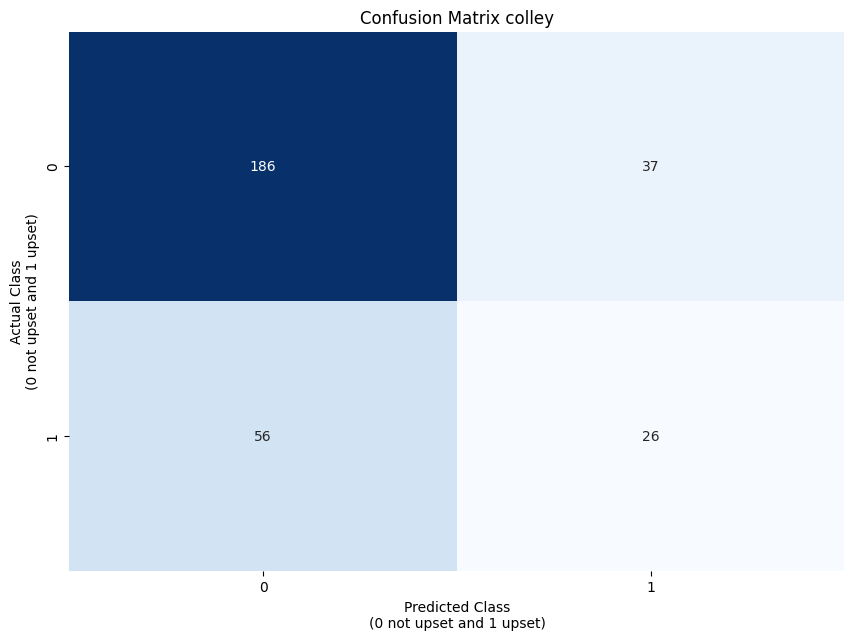

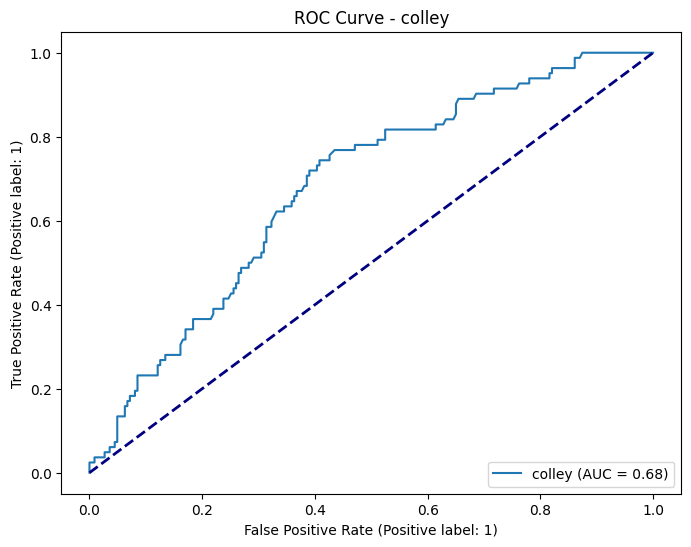

In [41]:
# Colley Ratings
ratings_model = 'colley'
ratings_function = ratings_functions.colley_ratings
num_folds = 5

# Call ratings function and run cross validation
(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)


Fold 1/5
Fold 1 Train Accuracy: 0.770, Train Recall: 0.333
Fold 1 Test Accuracy: 0.770, Test Recall: 0.312
Fold 2/5
Fold 2 Train Accuracy: 0.828, Train Recall: 0.500
Fold 2 Test Accuracy: 0.623, Test Recall: 0.125
Fold 3/5
Fold 3 Train Accuracy: 0.791, Train Recall: 0.409
Fold 3 Test Accuracy: 0.754, Test Recall: 0.312
Fold 4/5
Fold 4 Train Accuracy: 0.795, Train Recall: 0.400
Fold 4 Test Accuracy: 0.689, Test Recall: 0.235
Fold 5/5
Fold 5 Train Accuracy: 0.770, Train Recall: 0.385
Fold 5 Test Accuracy: 0.689, Test Recall: 0.235


,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,keener,1,1428623,27,2,1,1,0.124829,0.129532,28,12,1,1,0,0,0.300000
2,keener,1,201912,1,1,25,2,0.129532,0.130335,12,11,25,1,0,1,0.521739
3,keener,1,1324961,54,4,2,1,0.120252,0.131841,53,8,2,2,0,0,0.131148
4,keener,1,50127,2,1,41,2,0.131841,0.124792,8,29,2,2,0,0,0.216216
5,keener,1,846113,2,1,42,2,0.131841,0.124328,8,32,2,2,0,0,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,keener,5,274803,58,4,40,2,0.123476,0.122166,32,41,58,40,0,1,0.561644
302,keener,5,304202,42,2,55,3,0.121901,0.125851,44,26,55,55,1,1,0.628571
303,keener,5,1041547,46,3,57,4,0.127200,0.119837,22,55,46,46,0,0,0.285714
304,keener,5,836539,47,3,64,6,0.128985,0.120219,13,50,47,47,0,0,0.206349


,ratings_model,fold_number,team_no,rating,rank
1,keener,0,1,0.130041,12
2,keener,1,1,0.129532,12
3,keener,2,1,0.131002,11
4,keener,3,1,0.130994,8
5,keener,4,1,0.129786,14
...,...,...,...,...,...
380,keener,1,64,0.118077,61
381,keener,2,64,0.116845,61
382,keener,3,64,0.119265,56
383,keener,4,64,0.118867,57


Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener
0,1,0,1,1,1,12
1,1,1,1,1,5,12
2,1,2,1,1,1,11
3,1,3,1,1,1,8
4,1,4,1,1,1,14
...,...,...,...,...,...,...
379,64,1,64,56,64,61
380,64,2,64,62,64,61
381,64,3,64,60,64,56
382,64,4,64,57,64,57


Model name received: 'keener'
0.4650190868880104
0.557989098830499


,metric_id,metric,basic_position,massey,colley,keener
0,1,Cross-Validation Train Accuracy Mean,0.731,0.793,0.825,0.791
1,2,Cross-Validation Train Standard Deviation,0.002,0.015,0.011,0.021
2,3,Cross-Validation Test Accuracy Mean,0.731,0.695,0.695,0.705
3,4,Cross-Validation Test Accuracy Standard Deviation,0.008,0.057,0.062,0.053
4,5,Cross-Validation Train Recall Mean,0.000,0.418,0.515,0.405
5,6,Cross-Validation Train Recall Standard Deviation,0.000,0.051,0.050,0.054
6,7,Cross-Validation Test Recall Mean,0.000,0.268,0.318,0.244
7,8,Cross-Validation Test Recall Standard Deviation,0.000,0.082,0.095,0.069
8,9,Cross-Validation Train Log Loss,0.537,0.472,0.442,0.465
9,10,Cross-Validation Test Log Loss,0.537,0.576,0.563,0.558


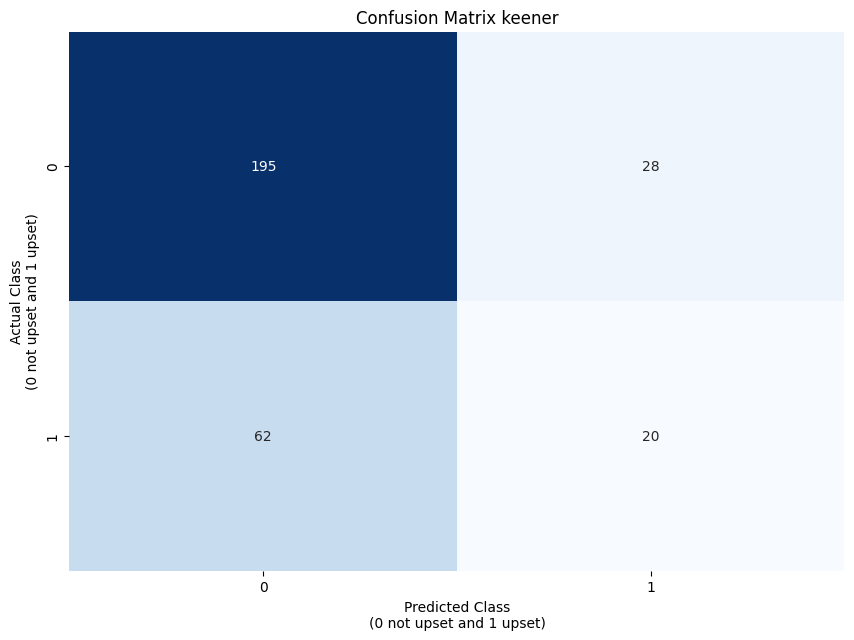

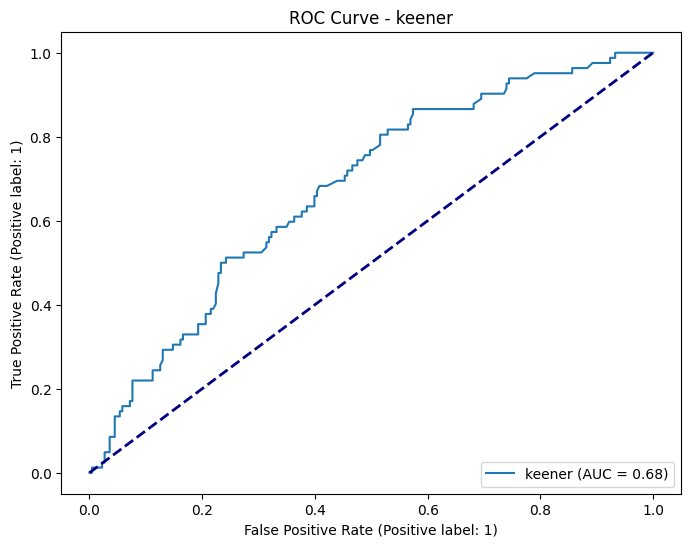

In [42]:
# Keener Ratings
ratings_model = 'keener'
ratings_function = ratings_functions.keener_ratings
num_folds = 5

# Call ratings function and run cross validation
(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)


Fold 1/5
Fold 1 Train Accuracy: 0.803, Train Recall: 0.530
Fold 1 Test Accuracy: 0.754, Test Recall: 0.375
Fold 2/5
Fold 2 Train Accuracy: 0.816, Train Recall: 0.561
Fold 2 Test Accuracy: 0.672, Test Recall: 0.375
Fold 3/5
Fold 3 Train Accuracy: 0.816, Train Recall: 0.515
Fold 3 Test Accuracy: 0.803, Test Recall: 0.500
Fold 4/5
Fold 4 Train Accuracy: 0.848, Train Recall: 0.615
Fold 4 Test Accuracy: 0.623, Test Recall: 0.294
Fold 5/5
Fold 5 Train Accuracy: 0.820, Train Recall: 0.554
Fold 5 Test Accuracy: 0.672, Test Recall: 0.235


,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,trueskill,1,1428623,27,2,1,1,28.926141,37.042183,16,2,1,1,0,0,0.111111
2,trueskill,1,201912,1,1,25,2,37.042183,32.748731,2,9,1,1,0,0,0.181818
3,trueskill,1,1324961,54,4,2,1,20.020612,34.072680,53,6,2,2,0,0,0.101695
4,trueskill,1,50127,2,1,41,2,34.072680,24.967022,6,31,2,2,0,0,0.162162
5,trueskill,1,846113,2,1,42,2,34.072680,21.064028,6,47,2,2,0,0,0.113208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,trueskill,5,274803,58,4,40,2,21.447040,19.714869,44,52,58,40,0,1,0.541667
302,trueskill,5,304202,42,2,55,3,24.346543,28.204193,34,19,55,55,1,1,0.641509
303,trueskill,5,1041547,46,3,57,4,25.703087,21.408404,25,46,46,46,0,0,0.352113
304,trueskill,5,836539,47,3,64,6,27.632205,17.694803,20,56,47,47,0,0,0.263158


,ratings_model,fold_number,team_no,rating,rank
1,trueskill,0,1,38.145486,1
2,trueskill,1,1,37.042183,2
3,trueskill,2,1,38.925231,1
4,trueskill,3,1,38.799527,1
5,trueskill,4,1,38.483163,1
...,...,...,...,...,...
380,trueskill,1,64,16.941835,60
381,trueskill,2,64,14.013553,63
382,trueskill,3,64,14.830695,64
383,trueskill,4,64,16.008558,61


Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill
0,1,0,1,1,1,12,1
1,1,1,1,1,5,12,2
2,1,2,1,1,1,11,1
3,1,3,1,1,1,8,1
4,1,4,1,1,1,14,1
...,...,...,...,...,...,...,...
379,64,1,64,56,64,61,60
380,64,2,64,62,64,61,63
381,64,3,64,60,64,56,64
382,64,4,64,57,64,57,61


Model name received: 'trueskill'
0.447859111986446
0.5795036298761539


,metric_id,metric,basic_position,massey,colley,keener,trueskill
0,1,Cross-Validation Train Accuracy Mean,0.731,0.793,0.825,0.791,0.820
1,2,Cross-Validation Train Standard Deviation,0.002,0.015,0.011,0.021,0.015
2,3,Cross-Validation Test Accuracy Mean,0.731,0.695,0.695,0.705,0.705
3,4,Cross-Validation Test Accuracy Standard Deviation,0.008,0.057,0.062,0.053,0.065
4,5,Cross-Validation Train Recall Mean,0.000,0.418,0.515,0.405,0.555
5,6,Cross-Validation Train Recall Standard Deviation,0.000,0.051,0.050,0.054,0.034
6,7,Cross-Validation Test Recall Mean,0.000,0.268,0.318,0.244,0.356
7,8,Cross-Validation Test Recall Standard Deviation,0.000,0.082,0.095,0.069,0.089
8,9,Cross-Validation Train Log Loss,0.537,0.472,0.442,0.465,0.448
9,10,Cross-Validation Test Log Loss,0.537,0.576,0.563,0.558,0.580


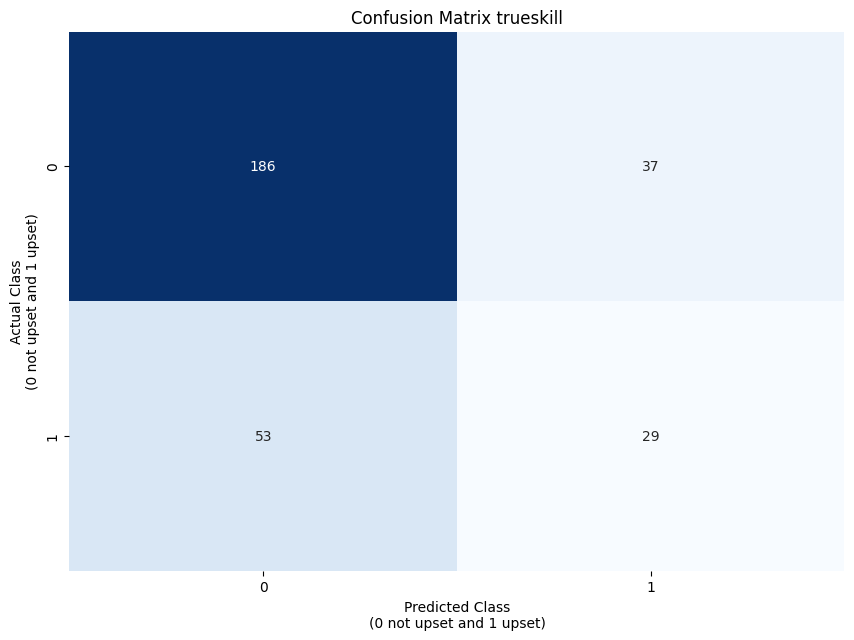

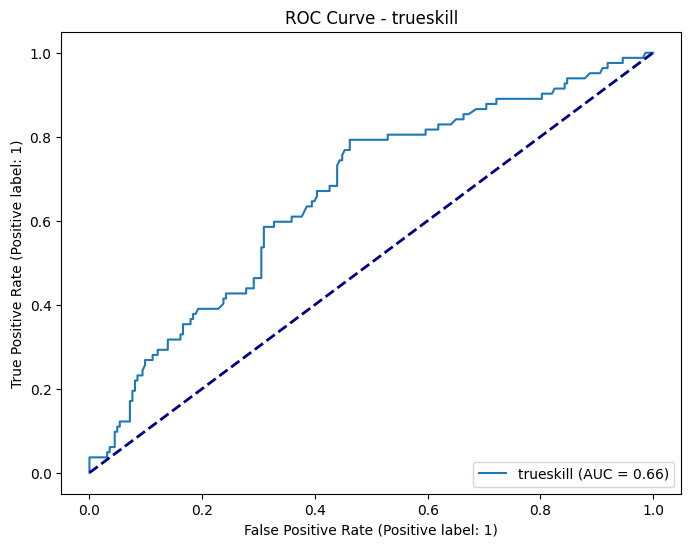

In [43]:
# Trueskill Ratings
ratings_model = 'trueskill'
ratings_function = ratings_functions.trueskill_ratings
num_folds = 5

# Call ratings function and run cross validation
(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 train_accuracies, train_recalls, test_accuracies, test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)


In [44]:
# Load all ranks df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

# Load confusion matrix df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')



100%|██████████| 1/1 [00:00<00:00, 12826.62it/s]


In [45]:
# Rank Aggregation functions called after ratings function have run and results inserted into Big Query

def borda_count_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_total'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].sum(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_total'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings

def average_rank_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_average'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].mean(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_average'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']
    display(all_ranks_df_fold)


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings


Fold 1/5
Fold 1 Train Accuracy: 0.799, Train Recall: 0.318
Fold 1 Test Accuracy: 0.803, Test Recall: 0.250
Fold 2/5
Fold 2 Train Accuracy: 0.811, Train Recall: 0.394
Fold 2 Test Accuracy: 0.639, Test Recall: 0.062
Fold 3/5
Fold 3 Train Accuracy: 0.779, Train Recall: 0.318
Fold 3 Test Accuracy: 0.770, Test Recall: 0.312
Fold 4/5
Fold 4 Train Accuracy: 0.828, Train Recall: 0.431
Fold 4 Test Accuracy: 0.689, Test Recall: 0.176
Fold 5/5
Fold 5 Train Accuracy: 0.799, Train Recall: 0.354
Fold 5 Test Accuracy: 0.721, Test Recall: 0.235


,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,borda_count,1,1428623,27,2,1,1,0.050000,0.333333,20,3,1,1,0,0,0.130435
2,borda_count,1,201912,1,1,25,2,0.333333,0.083333,3,12,1,1,0,0,0.200000
3,borda_count,1,1324961,54,4,2,1,0.017241,0.166667,58,6,2,2,0,0,0.093750
4,borda_count,1,50127,2,1,41,2,0.166667,0.031250,6,32,2,2,0,0,0.157895
5,borda_count,1,846113,2,1,42,2,0.166667,0.028571,6,35,2,2,0,0,0.146341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,borda_count,5,274803,58,4,40,2,0.022727,0.021277,44,47,58,40,0,1,0.516484
302,borda_count,5,304202,42,2,55,3,0.026316,0.030303,38,33,55,55,1,1,0.535211
303,borda_count,5,1041547,46,3,57,4,0.037037,0.018868,27,53,46,46,0,0,0.337500
304,borda_count,5,836539,47,3,64,6,0.047619,0.016129,21,62,47,47,0,0,0.253012


,ratings_model,fold_number,team_no,rating,rank
1,borda_count,0,1,0.516667,3
2,borda_count,1,1,0.333333,3
3,borda_count,2,1,0.500000,2
4,borda_count,3,1,1.000000,1
5,borda_count,4,1,0.500000,2
...,...,...,...,...,...
380,borda_count,1,64,0.015873,63
381,borda_count,2,64,0.015625,64
382,borda_count,3,64,0.015625,64
383,borda_count,4,64,0.015625,64


Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 0
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count
0,1,0,1,1,1,12,1,3
1,1,1,1,1,5,12,2,3
2,1,2,1,1,1,11,1,2
3,1,3,1,1,1,8,1,1
4,1,4,1,1,1,14,1,2
...,...,...,...,...,...,...,...,...
379,64,1,64,56,64,61,60,63
380,64,2,64,62,64,61,63,64
381,64,3,64,60,64,56,64,64
382,64,4,64,57,64,57,61,64


Model name received: 'borda_count'
0.45078649226687656
0.5474670892617742


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count
0,1,Cross-Validation Train Accuracy Mean,0.731,0.793,0.825,0.791,0.820,0.820
1,2,Cross-Validation Train Standard Deviation,0.002,0.015,0.011,0.021,0.015,0.015
2,3,Cross-Validation Test Accuracy Mean,0.731,0.695,0.695,0.705,0.705,0.705
3,4,Cross-Validation Test Accuracy Standard Deviation,0.008,0.057,0.062,0.053,0.065,0.065
4,5,Cross-Validation Train Recall Mean,0.000,0.418,0.515,0.405,0.555,0.555
5,6,Cross-Validation Train Recall Standard Deviation,0.000,0.051,0.050,0.054,0.034,0.034
6,7,Cross-Validation Test Recall Mean,0.000,0.268,0.318,0.244,0.356,0.356
7,8,Cross-Validation Test Recall Standard Deviation,0.000,0.082,0.095,0.069,0.089,0.089
8,9,Cross-Validation Train Log Loss,0.537,0.472,0.442,0.465,0.448,0.451
9,10,Cross-Validation Test Log Loss,0.537,0.576,0.563,0.558,0.580,0.547


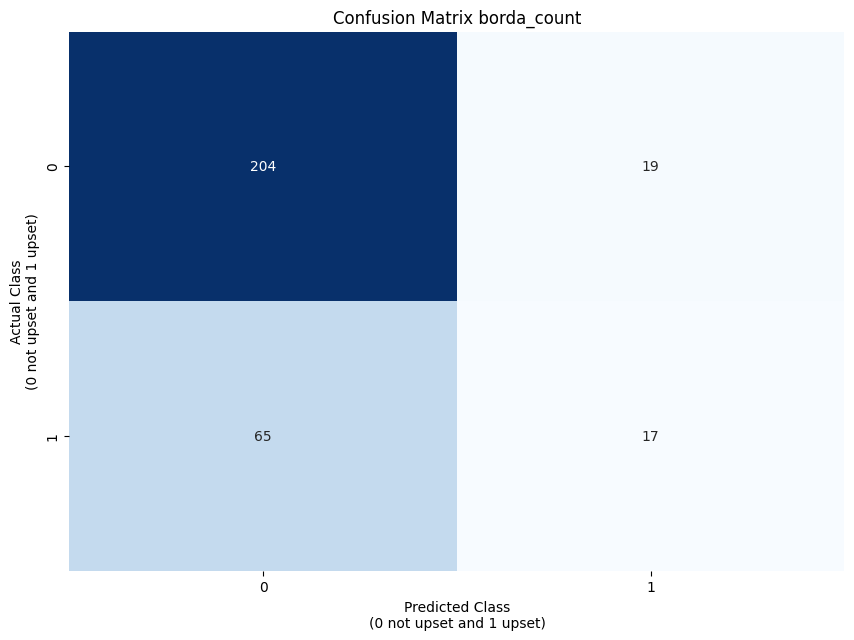

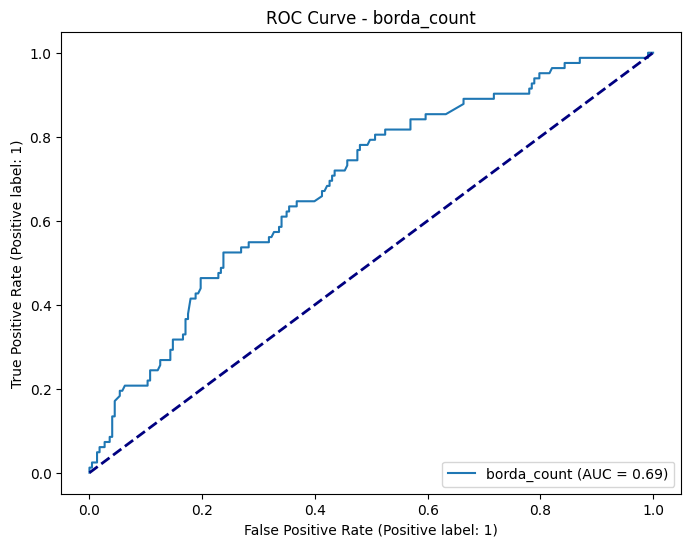

In [46]:
# Borda Count Aggregation
ratings_model = 'borda_count'
ratings_function = borda_count_aggregation
num_folds = 5

# Call ratings function and run cross validation
(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
5,1,1,1,1,5,12,2,4.2,3,0.333333
11,2,1,2,4,9,8,6,5.8,6,0.166667
12,3,1,3,3,1,4,1,2.4,1,1.000000
21,4,1,4,2,3,5,3,3.4,2,0.500000
28,5,1,5,8,6,2,4,5.0,4,0.250000
...,...,...,...,...,...,...,...,...,...,...
354,60,1,60,59,49,41,40,49.8,54,0.018519
360,61,1,61,52,52,60,58,56.6,61,0.016393
367,62,1,62,48,53,62,57,56.4,60,0.016667
377,63,1,63,64,62,59,64,62.4,64,0.015625


Fold 1 Train Accuracy: 0.799, Train Recall: 0.318
Fold 1 Test Accuracy: 0.803, Test Recall: 0.250
Fold 2/5


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
1,1,2,1,1,1,11,1,3.0,2,0.500000
8,2,2,2,2,7,4,8,4.6,5,0.200000
15,3,2,3,3,2,3,4,3.0,3,0.333333
22,4,2,4,4,3,1,2,2.8,1,1.000000
24,5,2,5,5,4,2,3,3.8,4,0.250000
...,...,...,...,...,...,...,...,...,...,...
355,60,2,60,63,51,47,49,54.0,57,0.017544
364,61,2,61,52,58,63,61,59.0,61,0.016393
371,62,2,62,59,63,60,64,61.6,63,0.015873
372,63,2,63,49,31,33,29,41.0,41,0.024390


Fold 2 Train Accuracy: 0.811, Train Recall: 0.394
Fold 2 Test Accuracy: 0.639, Test Recall: 0.062
Fold 3/5


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
2,1,3,1,1,1,8,1,2.4,1,1.000000
10,2,3,2,5,8,6,7,5.6,5,0.200000
16,3,3,3,2,3,4,4,3.2,3,0.333333
18,4,3,4,3,2,1,2,2.4,2,0.500000
27,5,3,5,6,5,2,3,4.2,4,0.250000
...,...,...,...,...,...,...,...,...,...,...
356,60,3,60,64,53,49,49,55.0,57,0.017544
361,61,3,61,47,52,51,53,52.8,56,0.017857
369,62,3,62,54,60,64,60,60.0,63,0.015873
373,63,3,63,61,43,45,47,51.8,54,0.018519


Fold 3 Train Accuracy: 0.779, Train Recall: 0.318
Fold 3 Test Accuracy: 0.770, Test Recall: 0.312
Fold 4/5


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
3,1,4,1,1,1,14,1,3.6,2,0.500000
9,2,4,2,4,7,3,7,4.6,5,0.200000
17,3,4,3,2,3,4,4,3.2,1,1.000000
23,4,4,4,11,5,6,5,6.2,6,0.166667
25,5,4,5,7,4,1,3,4.0,3,0.333333
...,...,...,...,...,...,...,...,...,...,...
358,60,4,60,64,56,53,54,57.4,60,0.016667
365,61,4,61,55,58,59,58,58.2,62,0.016129
366,62,4,62,46,48,63,52,54.2,56,0.017857
376,63,4,63,63,53,54,56,57.8,61,0.016393


Fold 4 Train Accuracy: 0.828, Train Recall: 0.431
Fold 4 Test Accuracy: 0.689, Test Recall: 0.176
Fold 5/5


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
4,1,5,1,2,3,14,2,4.4,4,0.250000
6,2,5,2,3,4,4,1,2.8,1,1.000000
13,3,5,3,1,1,7,8,4.0,3,0.333333
19,4,5,4,5,2,1,5,3.4,2,0.500000
29,5,5,5,6,7,2,4,4.8,5,0.200000
...,...,...,...,...,...,...,...,...,...,...
359,60,5,60,64,62,58,58,60.4,64,0.015625
362,61,5,61,55,56,62,60,58.8,63,0.015873
368,62,5,62,51,53,61,53,56.0,60,0.016667
375,63,5,63,63,47,52,45,54.0,57,0.017544


Fold 5 Train Accuracy: 0.799, Train Recall: 0.354
Fold 5 Test Accuracy: 0.721, Test Recall: 0.235


,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,average_rank,1,1428623,27,2,1,1,0.050000,0.333333,20,3,1,1,0,0,0.130435
2,average_rank,1,201912,1,1,25,2,0.333333,0.083333,3,12,1,1,0,0,0.200000
3,average_rank,1,1324961,54,4,2,1,0.017241,0.166667,58,6,2,2,0,0,0.093750
4,average_rank,1,50127,2,1,41,2,0.166667,0.031250,6,32,2,2,0,0,0.157895
5,average_rank,1,846113,2,1,42,2,0.166667,0.028571,6,35,2,2,0,0,0.146341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,average_rank,5,274803,58,4,40,2,0.022727,0.021277,44,47,58,40,0,1,0.516484
302,average_rank,5,304202,42,2,55,3,0.026316,0.030303,38,33,55,55,1,1,0.535211
303,average_rank,5,1041547,46,3,57,4,0.037037,0.018868,27,53,46,46,0,0,0.337500
304,average_rank,5,836539,47,3,64,6,0.047619,0.016129,21,62,47,47,0,0,0.253012


,ratings_model,fold_number,team_no,rating,rank
1,average_rank,0,1,0.516667,3
2,average_rank,1,1,0.333333,3
3,average_rank,2,1,0.500000,2
4,average_rank,3,1,1.000000,1
5,average_rank,4,1,0.500000,2
...,...,...,...,...,...
380,average_rank,1,64,0.015873,63
381,average_rank,2,64,0.015625,64
382,average_rank,3,64,0.015625,64
383,average_rank,4,64,0.015625,64


Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count,average_rank
0,1,0,1,1,1,12,1,3,3
1,1,1,1,1,5,12,2,3,3
2,1,2,1,1,1,11,1,2,2
3,1,3,1,1,1,8,1,1,1
4,1,4,1,1,1,14,1,2,2
...,...,...,...,...,...,...,...,...,...
379,64,1,64,56,64,61,60,63,63
380,64,2,64,62,64,61,63,64,64
381,64,3,64,60,64,56,64,64,64
382,64,4,64,57,64,57,61,64,64


Model name received: 'average_rank'
0.45078649226687656
0.5474670892617742


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count,average_rank
0,1,Cross-Validation Train Accuracy Mean,0.731,0.793,0.825,0.791,0.820,0.820,0.820
1,2,Cross-Validation Train Standard Deviation,0.002,0.015,0.011,0.021,0.015,0.015,0.015
2,3,Cross-Validation Test Accuracy Mean,0.731,0.695,0.695,0.705,0.705,0.705,0.705
3,4,Cross-Validation Test Accuracy Standard Deviation,0.008,0.057,0.062,0.053,0.065,0.065,0.065
4,5,Cross-Validation Train Recall Mean,0.000,0.418,0.515,0.405,0.555,0.555,0.555
5,6,Cross-Validation Train Recall Standard Deviation,0.000,0.051,0.050,0.054,0.034,0.034,0.034
6,7,Cross-Validation Test Recall Mean,0.000,0.268,0.318,0.244,0.356,0.356,0.356
7,8,Cross-Validation Test Recall Standard Deviation,0.000,0.082,0.095,0.069,0.089,0.089,0.089
8,9,Cross-Validation Train Log Loss,0.537,0.472,0.442,0.465,0.448,0.451,0.451
9,10,Cross-Validation Test Log Loss,0.537,0.576,0.563,0.558,0.580,0.547,0.547


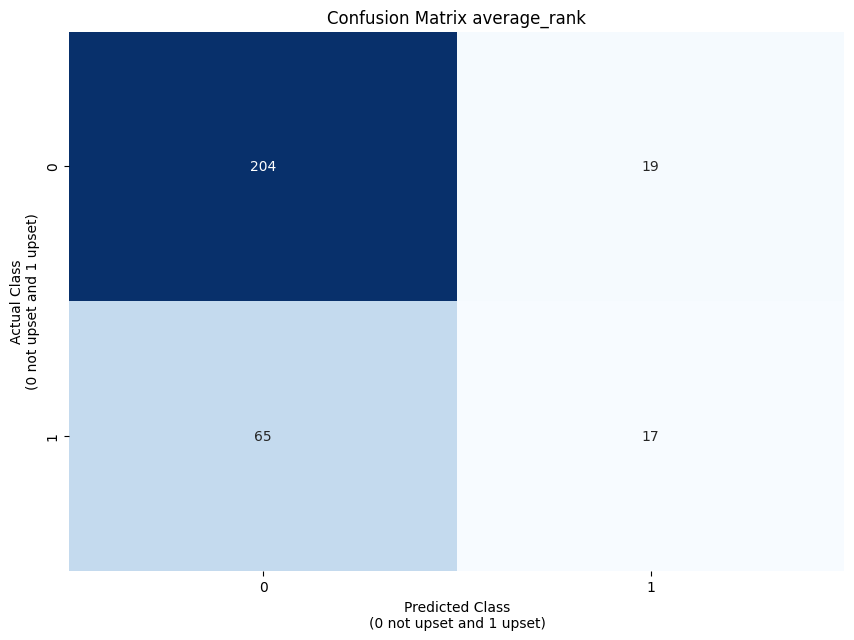

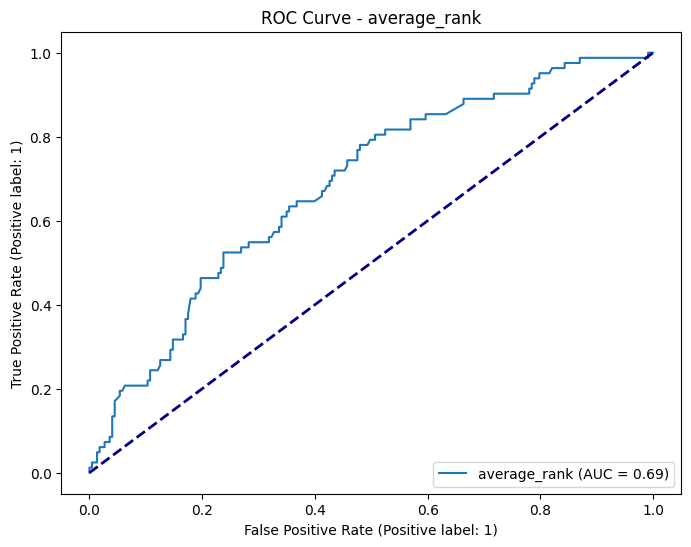

In [47]:
# Average Rank Aggregation
ratings_model = 'average_rank'
ratings_function = average_rank_aggregation
num_folds = 5

# Call ratings function and run cross validation
(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [48]:
# Load updated all ranks df to Big Query so Borda Count can be subsequently queried in local kemeny optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 13400.33it/s]


In [49]:
# Local Kemeny Optimisation

def local_kemeny_optimisation (fold_number, max_iterations=10):

    def kendall_tau_distance(ranking1, ranking2):
        distance = 0
        for i in range(len(ranking1)):
            for j in range(i + 1, len(ranking1)):
                if (ranking1[i] < ranking1[j]) != (ranking2[i] < ranking2[j]):
                    distance += 1
        return distance

    def total_kendall_tau_distance(candidate, rankings):
        return sum(kendall_tau_distance(candidate, ranking) for ranking in rankings.values())

    def local_kemeny_optimisation(rankings, initial_ranking, max_iterations):
        n_items = len(initial_ranking)

        current_ranking = initial_ranking.copy()
        current_distance = total_kendall_tau_distance(current_ranking, rankings)

        for iteration in range(max_iterations):
            improved = False
            for i in range(n_items - 1):
                new_ranking = current_ranking.copy()
                new_ranking[i], new_ranking[i+1] = new_ranking[i+1], new_ranking[i]
                new_distance = total_kendall_tau_distance(new_ranking, rankings)

                if new_distance < current_distance:
                    current_ranking = new_ranking
                    current_distance = new_distance
                    improved = True
                    print(f"Iteration {iteration + 1}: Improved distance to {current_distance}")
                    break

            if not improved:
                print(f"Stopped after {iteration + 1} iterations: No improvement")
                break

        if iteration == max_iterations - 1:
            print(f"Stopped after reaching maximum iterations ({max_iterations})")

        return current_ranking

    # Authenticate using the loaded key
    # credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    # Query to get the data
    all_ranks_query = f"""
        SELECT * FROM analysis_layer.ratings_model_ranks WHERE fold_number = {fold_number}
    """

    all_ranks_df = client.query(all_ranks_query).to_dataframe()

    # Create dictionary of rankings
    rankings = {
        'basic_position': all_ranks_df['basic_position'].tolist(),
        'massey': all_ranks_df['massey'].tolist(),
        'colley': all_ranks_df['colley'].tolist(),
        'keener': all_ranks_df['keener'].tolist(),
        'trueskill': all_ranks_df['trueskill'].tolist()
    }

    # Use Borda count as initial ranking
    borda_count = all_ranks_df['borda_count'].tolist()

    # Perform local Kemeny optimization
    optimized_ranking = local_kemeny_optimisation(rankings, borda_count, max_iterations)
    print("\nTotal Kendall tau distance (Borda Count):", total_kendall_tau_distance(borda_count, rankings))
    print("Total Kendall tau distance (Optimized):", total_kendall_tau_distance(optimized_ranking, rankings))

    # Show which teams changed positions
    team_nos = all_ranks_df['team_no'].tolist()

    # Create a mapping from team number to rank for both rankings
    borda_mapping = {team: rank for rank, team in enumerate(borda_count)}
    optimized_mapping = {team: rank for rank, team in enumerate(optimized_ranking)}

    changes = []
    for team in team_nos:
        borda_rank = borda_mapping.get(team, -1)
        optimized_rank = optimized_mapping.get(team, -1)
        if borda_rank != optimized_rank:
            changes.append((team, borda_rank, optimized_rank))

    print("\nTeams that changed positions (Team, Old Position, New Position):")
    for change in changes:
        print(f"Team {change[0]}: {change[1]} -> {change[2]}")

    # Create a DataFrame with the optimized ranking
    optimized_df = pd.DataFrame({
        'team_no': team_nos,
        'overall_rank': optimized_ranking
    })

    # Calculate the rating based on the optimized ranking
    optimized_df['rating'] = 1 / optimized_df['overall_rank']

    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(optimized_df['team_no'], optimized_df['rating']))

    return ratings


Fold 1/5
Iteration 1: Improved distance to 1157
Iteration 2: Improved distance to 1156
Iteration 3: Improved distance to 1155
Stopped after 4 iterations: No improvement

Total Kendall tau distance (Borda Count): 1158
Total Kendall tau distance (Optimized): 1155

Teams that changed positions (Team, Old Position, New Position):
Team 39: 55 -> 54
Team 40: 54 -> 55
Team 60: 61 -> 60
Team 61: 60 -> 61
Team 63: 63 -> 62
Team 64: 62 -> 63
Fold 1 Train Accuracy: 0.799, Train Recall: 0.318
Fold 1 Test Accuracy: 0.803, Test Recall: 0.250
Fold 2/5
Iteration 1: Improved distance to 1150
Iteration 2: Improved distance to 1149
Iteration 3: Improved distance to 1148
Stopped after 4 iterations: No improvement

Total Kendall tau distance (Borda Count): 1151
Total Kendall tau distance (Optimized): 1148

Teams that changed positions (Team, Old Position, New Position):
Team 1: 3 -> 2
Team 3: 2 -> 3
Team 14: 12 -> 11
Team 15: 11 -> 12
Team 52: 42 -> 41
Team 53: 41 -> 42
Fold 2 Train Accuracy: 0.811, Train 

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,local_kemeny_optimisation,1,1428623,27,2,1,1,0.050000,0.333333,20,3,1,1,0,0,0.130435
2,local_kemeny_optimisation,1,201912,1,1,25,2,0.333333,0.083333,3,12,1,1,0,0,0.200000
3,local_kemeny_optimisation,1,1324961,54,4,2,1,0.017241,0.166667,58,6,2,2,0,0,0.093750
4,local_kemeny_optimisation,1,50127,2,1,41,2,0.166667,0.031250,6,32,2,2,0,0,0.157895
5,local_kemeny_optimisation,1,846113,2,1,42,2,0.166667,0.028571,6,35,2,2,0,0,0.146341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,local_kemeny_optimisation,5,274803,58,4,40,2,0.022727,0.020833,44,48,58,40,0,1,0.521739
302,local_kemeny_optimisation,5,304202,42,2,55,3,0.026316,0.030303,38,33,55,55,1,1,0.535211
303,local_kemeny_optimisation,5,1041547,46,3,57,4,0.037037,0.018868,27,53,46,46,0,0,0.337500
304,local_kemeny_optimisation,5,836539,47,3,64,6,0.047619,0.016129,21,62,47,47,0,0,0.253012


,ratings_model,fold_number,team_no,rating,rank
1,local_kemeny_optimisation,0,1,0.516667,2
2,local_kemeny_optimisation,1,1,0.333333,3
3,local_kemeny_optimisation,2,1,0.500000,2
4,local_kemeny_optimisation,3,1,1.000000,1
5,local_kemeny_optimisation,4,1,0.500000,2
...,...,...,...,...,...
380,local_kemeny_optimisation,1,64,0.015625,64
381,local_kemeny_optimisation,2,64,0.015625,64
382,local_kemeny_optimisation,3,64,0.015625,64
383,local_kemeny_optimisation,4,64,0.015625,64


Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count,average_rank,local_kemeny_optimisation
0,1,0,1,1,1,12,1,3,3,2
1,1,1,1,1,5,12,2,3,3,3
2,1,2,1,1,1,11,1,2,2,2
3,1,3,1,1,1,8,1,1,1,1
4,1,4,1,1,1,14,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...
379,64,1,64,56,64,61,60,63,63,64
380,64,2,64,62,64,61,63,64,64,64
381,64,3,64,60,64,56,64,64,64,64
382,64,4,64,57,64,57,61,64,64,64


Model name received: 'local_kemeny_optimisation'
0.45081673217087026
0.5467991733602464


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count,average_rank,local_kemeny_optimisation
0,1,Cross-Validation Train Accuracy Mean,0.731,0.793,0.825,0.791,0.820,0.820,0.820,0.820
1,2,Cross-Validation Train Standard Deviation,0.002,0.015,0.011,0.021,0.015,0.015,0.015,0.015
2,3,Cross-Validation Test Accuracy Mean,0.731,0.695,0.695,0.705,0.705,0.705,0.705,0.705
3,4,Cross-Validation Test Accuracy Standard Deviation,0.008,0.057,0.062,0.053,0.065,0.065,0.065,0.065
4,5,Cross-Validation Train Recall Mean,0.000,0.418,0.515,0.405,0.555,0.555,0.555,0.555
5,6,Cross-Validation Train Recall Standard Deviation,0.000,0.051,0.050,0.054,0.034,0.034,0.034,0.034
6,7,Cross-Validation Test Recall Mean,0.000,0.268,0.318,0.244,0.356,0.356,0.356,0.356
7,8,Cross-Validation Test Recall Standard Deviation,0.000,0.082,0.095,0.069,0.089,0.089,0.089,0.089
8,9,Cross-Validation Train Log Loss,0.537,0.472,0.442,0.465,0.448,0.451,0.451,0.451
9,10,Cross-Validation Test Log Loss,0.537,0.576,0.563,0.558,0.580,0.547,0.547,0.547


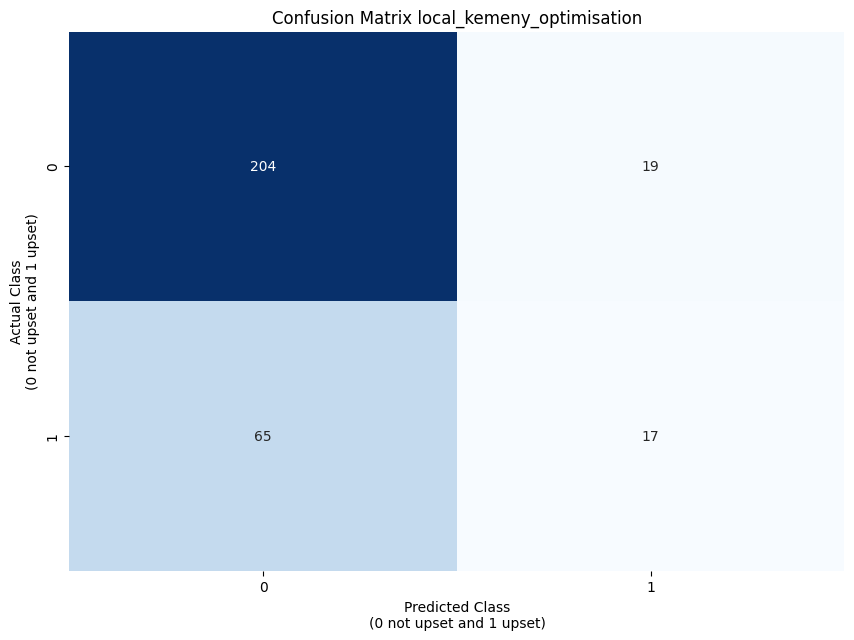

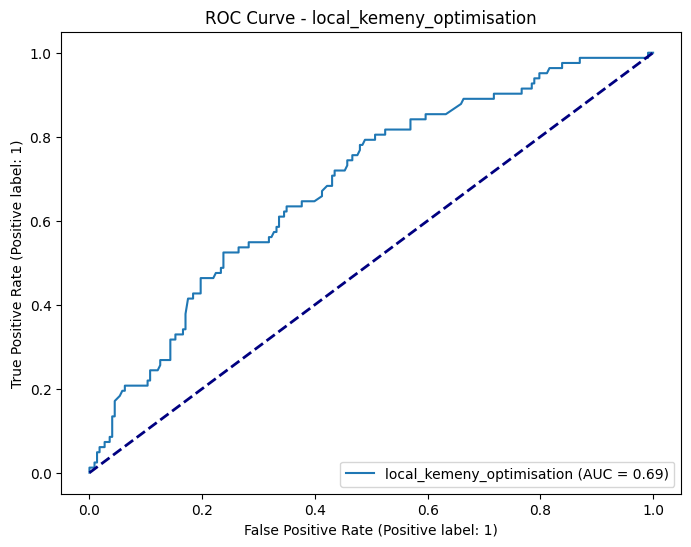

In [50]:
# Local Kemeny Optimisation

ratings_model = 'local_kemeny_optimisation'
ratings_function = local_kemeny_optimisation
num_folds = 5

# Call ratings function and run cross validation
(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results.create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [51]:
# Load final ranks including Local Kemeny Optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 14873.42it/s]


In [52]:
# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df.to_excel("all_rating_ranking_results.xlsx")